In [1]:
import sys, os
import serial
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import win32com.client
from astropy.io import fits
import threading
import nbimporter
from picoammeter_control import (
    send_cmd,
    query,
    init_cmds
)
from camera_control_ascom import (
    take_ramp,
    camera_init,
    populate_header
)
sys.path.insert(0, os.path.abspath('.'))
sys.path.insert(0, os.path.abspath('filter_wheel_control'))
from filter_wheel_control.wheel_controller import (
    list_devices,
    open_device,
    get_position,
    get_position_count,
    set_position,
    close_device
)
from data_helper_functions import (
    init_wheels,
    close_wheels,
    camera_init,
    picoam_stability,
    picoam_worker_exp,
    camera_with_picoam,
    collect_var_exp,
    var_exp_graphs,
    capture_frame,
    measure_ptc_point,
    get_gain,
    picoam_worker_filters,
    camera_with_filters,
    collect_var_filters,
    compare_exp_and_filter,
    collect_bias_frames
)

In [2]:
camera_init()
cam_name = "ASCOM.ASICamera2_2.Camera"
save_path= "C:/Users/Jonah/fits_imgs"

You selected: ASCOM.ASICamera2_2.Camera


In [3]:
min_exp = 0.0001
max_exp = 2.5

In [ ]:
# picoam_stability(read_time = .5, save = save_path, port='COM5')

In [6]:
init_wheels(print_stuff=False)
close_wheels()

In [7]:
e_per_adu = get_gain(cam_name="ASCOM.ASICamera2_2.Camera", n_frames=3, print_stuff=True, exp_list=[min_exp, min_exp*10, min_exp*100, min_exp*200, min_exp*500, min_exp*1000])

Measuring PTC at exp=0.001s …
taking frame
taking frame
taking frame
taking frame
taking frame
taking frame
  μ=54.2 ADU, var_diff=32398.9 ADU²
Measuring PTC at exp=0.010s …
taking frame
taking frame
taking frame
taking frame
taking frame
taking frame
  μ=539.8 ADU, var_diff=332218.4 ADU²
Measuring PTC at exp=0.100s …
taking frame
taking frame
taking frame
taking frame
taking frame
taking frame
  μ=5985.0 ADU, var_diff=2815079.5 ADU²
Measuring PTC at exp=0.200s …
taking frame
taking frame
taking frame
taking frame
taking frame
taking frame
  μ=12132.6 ADU, var_diff=5350428.6 ADU²
Measuring PTC at exp=0.500s …
taking frame
taking frame
taking frame
taking frame
taking frame
taking frame
  μ=30589.4 ADU, var_diff=13107540.4 ADU²
Measuring PTC at exp=1.000s …
taking frame
taking frame
taking frame
taking frame
taking frame
taking frame
  μ=61704.6 ADU, var_diff=21236608.0 ADU²
gain = 0.00275 e⁻/ADU


KEITHLEY INSTRUMENTS INC.,MODEL 6485,4070587,C01   Jun 23 2010 12:22:00/A02  /H
Camera connected: ASCOM.ASICamera2_2.Camera, Size: 8288x5644, Temperature: 22.80C
Taking frames at 0.00010000 seconds (exposure time 1/50)
Taking frames at 0.00012296 seconds (exposure time 2/50)
Taking frames at 0.00015118 seconds (exposure time 3/50)
Taking frames at 0.00018589 seconds (exposure time 4/50)
Taking frames at 0.00022857 seconds (exposure time 5/50)
Taking frames at 0.00028104 seconds (exposure time 6/50)
Taking frames at 0.00034556 seconds (exposure time 7/50)
Taking frames at 0.00042489 seconds (exposure time 8/50)
Taking frames at 0.00052243 seconds (exposure time 9/50)
Taking frames at 0.00064237 seconds (exposure time 10/50)
Taking frames at 0.00078984 seconds (exposure time 11/50)
Taking frames at 0.00097116 seconds (exposure time 12/50)
Taking frames at 0.00119412 seconds (exposure time 13/50)
Taking frames at 0.00146825 seconds (exposure time 14/50)
Taking frames at 0.00180532 seconds

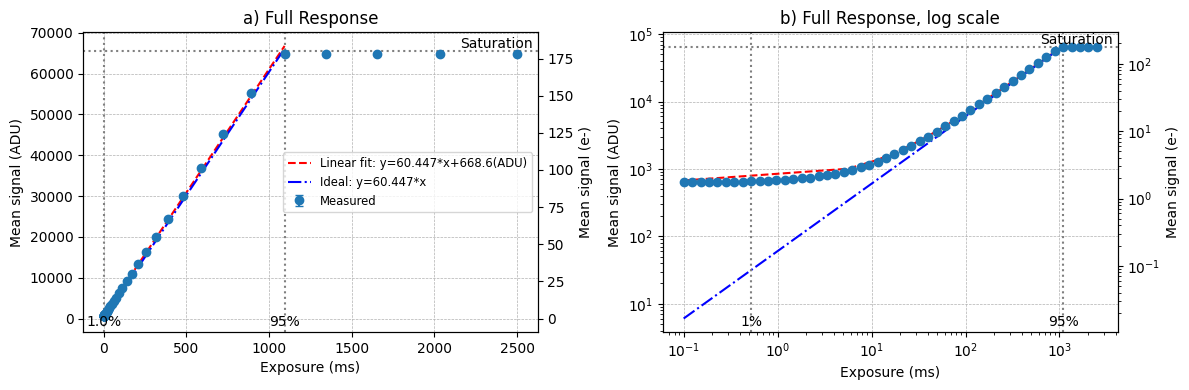

Figure saved to exp_0.0001-2.5_linearity_figure.png


In [10]:
I_flat, Q_ramp, mean_signal, std_signal, bit_depth, exp_times, exp_low, exp_high, exp_50 = (collect_var_exp(cam_name=cam_name, num_exp=50, num_frames=10, exp_low = min_exp, exp_high = max_exp, save_path=save_path))
var_exp_graphs(mean_signal, std_signal, bit_depth, exp_times, exp_low, exp_high, save=True, e_per_adu=e_per_adu, min_percent=0.01, max_percent= 0.95, percent_change=False)

In [11]:
signals_f, Q_filt = collect_var_filters(save_path=save_path, cam_name=cam_name, exp_50=exp_50, num_frames=10)


starting filter 1
starting filter 2
starting filter 3
starting filter 4
starting filter 5
starting filter 6
Wrote per-frame filter data to C:/Users/Jonah/fits_imgs\filter_frame_data.csv
finished


In [12]:
bias_level = collect_bias_frames(cam_name = cam_name,num_frames=500, exp_low=min_exp, save_path=save_path)
print("bias level: ", bias_level)

Camera connected: ASCOM.ASICamera2_2.Camera, Size: 8288x5644, Temperature: 23.20C
Taking frames at 0.00010000 seconds (exposure time 1/1)
exp res: 0.00000100 seconds
camera connected again
Bias cube saved to C:/Users/Jonah/fits_imgs\bias_stack.fits
Bias means saved to C:/Users/Jonah/fits_imgs\bias_means.csv
bias level:  633.604310848


533.604310848
Figure saved to exp_vs_filter_figure.png


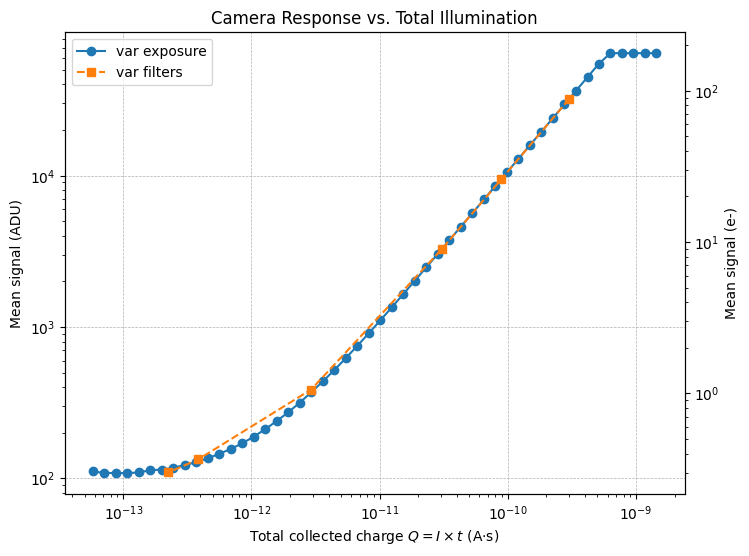

In [13]:
compare_exp_and_filter(e_per_adu = e_per_adu, Q_ramp=Q_ramp, Q_filt=Q_filt, signals_f=signals_f, mean_signal=mean_signal, bias_level=(bias_level-100), save=True)
